In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import model_SEIRX
import agent_patient
import importlib
import viz
importlib.reload(viz)
importlib.reload(model_SEIRX)
importlib.reload(agent_patient)

<module 'agent_patient' from '/home/jana/CSH/medical/analysis/nursing_homes/agent_patient.py'>

In [4]:
N_employees = 10
N_steps = 100
WB = 2
G = nx.readwrite.gpickle.read_gpickle('testdata/WB{}_static_interactions.gpickle'\
                                  .format(WB))
N_patients = len(G.nodes)

SIR_model = model_SEIRX.SIR(G, N_employees, 0)
for i in range(N_steps):
    SIR_model.step()

In [5]:
pop_numbers = SIR_model.datacollector.get_model_vars_dataframe()
pop_numbers['S_patient'] = N_patients - pop_numbers.E_patient - pop_numbers.I_patient - pop_numbers.R_patient

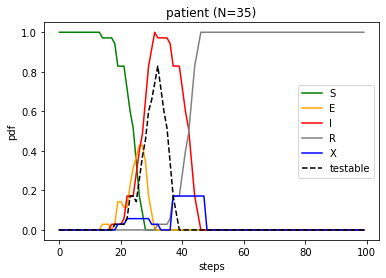

In [6]:
importlib.reload(viz)
fig, ax = plt.subplots()
viz.draw_infection_timeline(SIR_model, 'patient', ax)

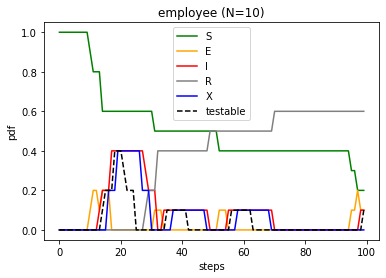

In [7]:
importlib.reload(viz)
fig, ax = plt.subplots()
viz.draw_infection_timeline(SIR_model, 'employee', ax)

In [8]:
pos = nx.drawing.layout.spring_layout(G, dim=2, weight='weight')

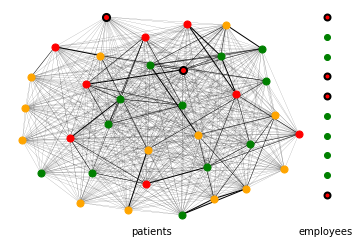

In [10]:
importlib.reload(viz)
fig, ax = plt.subplots()
viz.draw_states(SIR_model, 25, pos, ax)